## 实验8：USB KEY中CRT-RSA的SPA

### 核心问题
1、观察平方、乘两种操作的差异

2、噪声干扰和精度的要求

##### 导入库函数和能量波形数据

In [ ]:
import plotly.graph_objs as go
import scipy.io as sio
import scipy.signal as signal
from scipy.ndimage import gaussian_filter1d
import numpy as np

In [ ]:
# 加载.mat文件
mat_file = sio.loadmat('trace10.mat')

##### 截取f1和f2部分变量

In [ ]:
# 获取变量
data = mat_file['trace']

In [ ]:
# 获取中间两段数据
start_index1 = 1306850
end_index1 = 2046440
middle_data1 = data[2, start_index1:end_index1]

#start_index2 = 2387000
#end_index2 = 3143000
#middle_data2 = data[0, start_index2:end_index2]

##### 绘制原始图像

In [ ]:
# 绘制原始图像
fig = go.Figure()
fig.add_trace(go.Scatter(x = list(range(len(middle_data1))), y = middle_data1, mode='lines')) # 原始图像
fig.show()

##### 进行高斯滤波观察

In [ ]:
# 对中间一段数据进行高斯滤波
sigma = 20
middle_filtered_data1 = gaussian_filter1d(middle_data1, sigma=sigma)
# middle_filtered_data2 = gaussian_filter1d(middle_data2, sigma=sigma)

fig.add_trace(go.Scatter(x = list(range(len(middle_filtered_data1))), y = middle_filtered_data1, mode='lines')) # 高斯滤波图像
fig.show()

##### 切片区分

采用滑动平均滤波和中值滤波对波形进行处理

In [ ]:
# 滑动平均滤波
window_size = 200  # 设置滑动窗口大小
pad_width = (window_size + 1) // 2 # 边缘填充
window = np.ones(window_size) / float(window_size)
middle_smooth_data1 = np.convolve(middle_data1, window, 'valid')
#middle_smooth_data2 = np.convolve(middle_data2, window, 'valid')
# 边缘填充
middle_smooth_data1 = np.pad(middle_smooth_data1, (pad_width, pad_width), mode='edge')
#middle_smooth_data2 = np.pad(middle_smooth_data2, (pad_width, pad_width), mode='edge')

# 中值滤波
middle_medfilt_data1 = signal.medfilt(middle_smooth_data1, kernel_size = 101)
#middle_medfilt_data2 = signal.medfilt(middle_smooth_data2, kernel_size = 101)

fig.add_trace(go.Scatter(x = list(range(len(middle_smooth_data1))), y = middle_smooth_data1, mode='lines')) # 滑动滤波图像
fig.add_trace(go.Scatter(x = list(range(len(middle_medfilt_data1))), y = middle_medfilt_data1, mode='lines')) # 中值滤波图像
fig.show()

采用signal中find_peaks函数查找波谷

In [ ]:
# 查找峰值
neg_data = -middle_medfilt_data1
peaks , _ = signal.find_peaks(neg_data, distance = 600)
neg_peaks = -neg_data[peaks]

print(len(peaks))

sep_test = np.zeros(len(middle_data1))
for i in range(len(sep_test)):
    if i in peaks:
        sep_test[i] = -0.5

fig.add_trace(go.Scatter(x = list(range(len(sep_test))), y = sep_test, mode='lines')) # 绘制反向尖峰
fig.show()

In [ ]:
# 统计操作类型数目
operation_SM = len(peaks) - 1 - 512
operation_S = 512 - operation_SM

共得到747个反向尖峰，说明共746个操作，对于512bit的运算，应该有234个平方+乘操作，278个平方操作

##### 统计运算时间

In [ ]:
# 计算每个操作的运行时间
runtime = []
for i in range(len(peaks)-1):
    runtime.append(peaks[i+1]-160-peaks[i]-120)

In [ ]:
# 绘制散点图
fig_variance = go.Figure(data=go.Scatter(x=list(range(len(runtime))), y=runtime, mode='markers'))
fig_variance.show()

##### 特征识别

In [ ]:
# 快速排序查找分割点
def quick_sort(arr):
    if len(arr) <= 1:
        return arr
    else:
        pivot = arr[0]
        left = [x for x in arr[1:] if x >= pivot]
        right = [x for x in arr[1:] if x < pivot]
        return quick_sort(left) + [pivot] + quick_sort(right)

sorted_runtime = quick_sort(runtime)
print(sorted_runtime[operation_SM-1]) # 分割点

In [ ]:
# 特征识别
symbol_list = []
feature_spiltpoint = sorted_runtime[operation_SM-1]

for i in range(len(runtime)-1):
    if runtime[i] < feature_spiltpoint:
        symbol_list.append('S')
    elif runtime[i] > feature_spiltpoint-1:
        symbol_list.append('M')

print(len(symbol_list))
print(symbol_list)

In [ ]:
# 查找目标操作序列
encode_str = ''.join(symbol_list)
test_str = 'SSSMSSSSSMSSSSM'
index = encode_str.find(test_str)

if index != -1:
    print(f"索引值为 {index}")
else:
    print(f"原字符串中不包含字符串 '{test_str}'")

print(encode_str[index:index+91])

##### 提高准确度

投票法

记录九条波得到的操作结果，这里采用投票法可以得到正确的答案

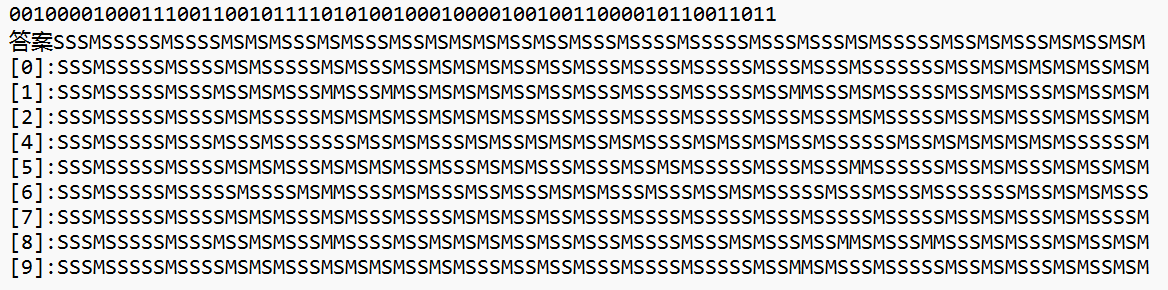

平均值法

对九条波得到的结果取平均值，可以比较明显区分平方和乘两种操作在运行时间上的界限

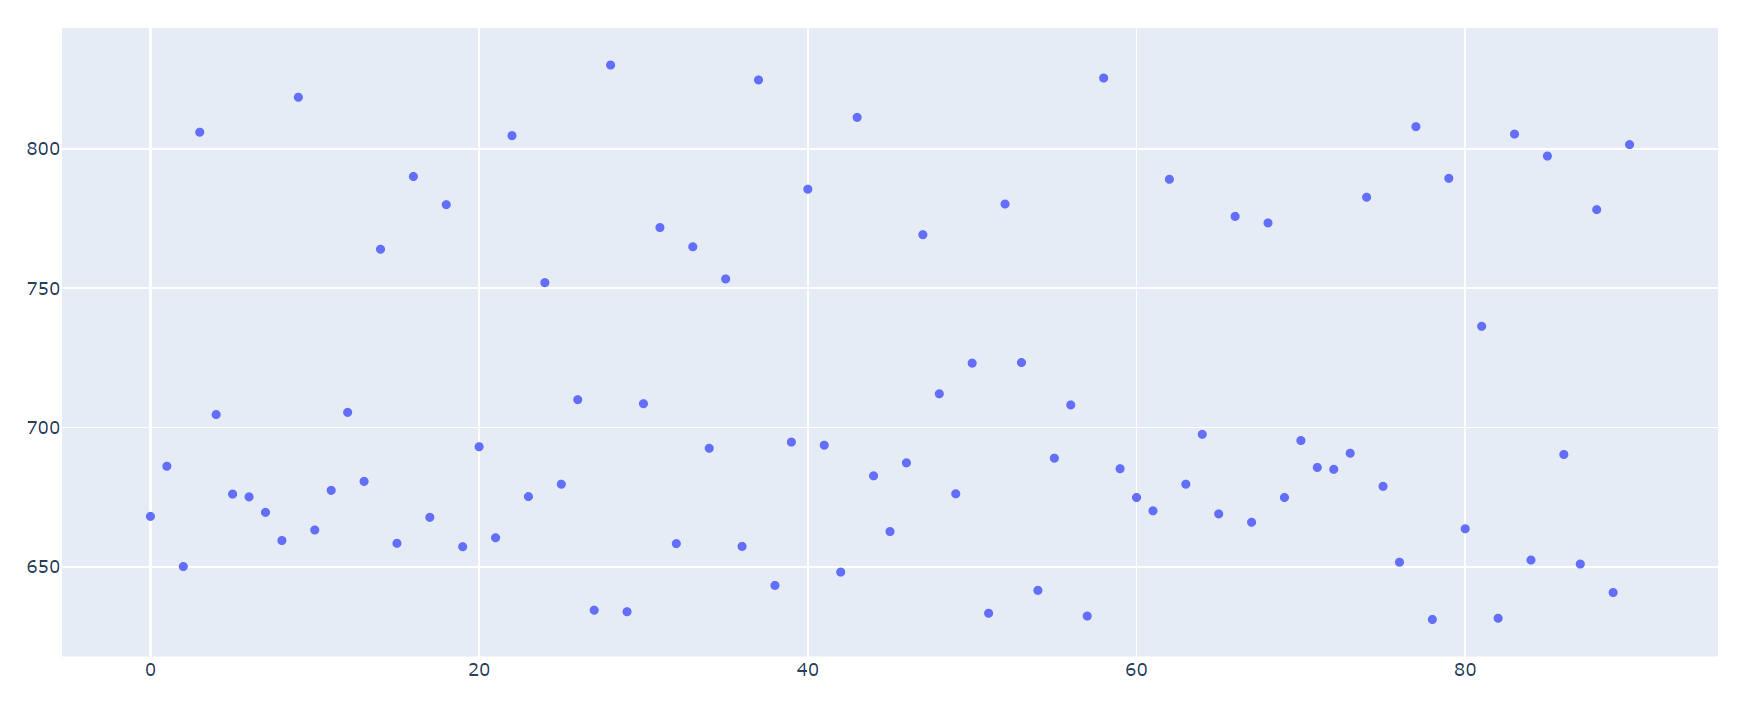

In [ ]:
# 特征识别
with open('average_list.txt', 'r') as file:
    average_list = file.readline()
average_list = list(map(int, eval(average_list)))

symbol_list = []
feature_spiltpoint = 748
for i in range(len(average_list)-1):
    if average_list[i] < feature_spiltpoint and average_list[i+1] < feature_spiltpoint:
        symbol_list.append('0')
    elif average_list[i] < feature_spiltpoint and average_list[i+1] > feature_spiltpoint-1:
        symbol_list.append('1')

symbol_str = ''.join(symbol_list)
print(symbol_str)

##### 总结

1、综合利用横轴纵轴信息

2、如何在噪音干扰和精确度不高的情况下提高准确度

3、如何抹除轮询噪音